# Array expression profiling: direct inhibition of the NOTCH transcription complex

**Goals**

We will try to reproduce some of the differential expression results obtained by the paper *Direct inhibition of the NOTCH transcription complex*. In this paper, Moellering et al. try to design and synthesize a peptide able to inhibit NOTCH transcription factor for the treatment of individuals affected by Acute lymphoblastic leukemia (T-ALL).

NOTCH proteins regulate signaling pathways involved in cellular differentiation, proliferation and apoptosis. 
Overactive Notch signaling as been observed in numerous cancers and has been extensively studied in the context of T-ALL where more than 50% of pateints have mutant NOTCH1.
Small molecule modulators of these proteins would be important for understanding the role of NOTCH proteins in malignant and normal biological processes.

The authors measure the global changes in gene expression upon treatment of the human T-ALL cell lines HPB-ALL and KOPT-K1 with either vehicle alone dimethylsulphoxide (DMSO) control or the designed peptite SAHM1, an alpha-helical hydrocarbon peptide derived from the MAML1 co-activator protein.
 	
**Summary design**

They triplicate cultures of KOPT-K1 or HPB-ALL cells that were treated with either DMSO or SAHM1 (20 uM) for 24 hours. Total RNA was extracted and hybridized to Affymetrix human U133 plus 2.0 microarrays (three arrays per treatment per cell line for a total of 12 arrays).


## Pipeline

## Python imports

In [5]:
import rpy2.rinterface
%reload_ext rpy2.ipython

## R imports

In [254]:
%%R
##1. Load libraries
library("affy")
library("limma")
library("genefilter")
library(simpleaffy)
library(hgu133plus2.db)
wd <- "/Users/nandoide/misc_work/Desktop/uni/TRREP"
setwd(wd)

## Functions

In [281]:
%%R

import_CEL <- function(pattern) {
    # Import CEL files into affiBatch object
    files <- list.files(pattern = pattern)
    names <- gsub(".CEL.gz", "", files)
    abatch <- ReadAffy(filenames = files,  compress = TRUE, sampleNames = names)
    return(abatch)
}

create_eset <- function(affyBatch) {
    # Generates object eset (class ExprSet), 
    # expresso function provides intensities in log scale
    return(expresso(affyBatch,
             bg.correct = TRUE, 
             bgcorrect.method="rma",
             normalize = TRUE, 
             normalize.method="quantiles", 
             pmcorrect.method="pmonly", 
             summary.method="medianpolish",
             verbose = TRUE))
}

boxplots <- function(affyBatch, eset, title) {
    # Generate BOXPLOTS before and after normalization
    boxplot(affyBatch,
        main=paste0("Boxplot Before Normalization ", title),
        col = "lightgrey")
    df_eset <- as.data.frame(exprs(eset))
    
    boxplot(data.frame(df_eset),
        main=paste0("Boxplot After Normalization (log scale) ", title), col = "white")
}

create_TopTable <- function(eset, control_samples=c(1,1,1,0,0,0)) {
    # Generate Toptable with limma 
    
    # Data filtering using IQR.
    esetIQR <- varFilter(eset, var.func=IQR, var.cutoff=0.5, filterByQuantile=TRUE)

    # Differential expression analysis.#######
    r_control_samples <- 1 - control_samples
    design <- cbind(DMSO=control_samples, SAHM1=r_control_samples)

    rownames(design) <- colnames(eset)

    #7. Contrasts matrix.
    cont.matrix <- makeContrasts(DMSO_SAHM1 = SAHM1 - DMSO, levels = design)

    #8. Obtaining differentially expressed genes (DEGs)
    #Linear model and eBayes 
    fit <- lmFit(esetIQR, design)  ##getting DEGs from IQR 
    fit2 <- contrasts.fit(fit, cont.matrix)
    fit2 <- eBayes(fit2)

    #Table with DEGs results
    toptableIQR <- topTable(fit2, number=dim(exprs(esetIQR))[1], adjust.method="BH", sort.by="p")
    return(toptableIQR)
}

anotate_TopTable <- function(toptable) {
    # Obtain gene names from probe names and chip symbol dataset
    probenames_toptable <- as.character(rownames(toptable ))
    genesymbols_toptable <- as.character(mget(probenames_toptable, hgu133plus2SYMBOL))
    # Annotated gene table
    toptable_anot <- cbind(Symbol = genesymbols_toptable, toptable)
    return(toptable_anot)
}

generank_table <- function(toptable, rnk.file) {
    # Generate rank of table top 50 upregulared and top 50 downregulated from 250 better
    # adjustes p-values
    more_significant = toptable[order(toptable$adj.P.Val, decreasing = FALSE),][1:250,]
    up_50 = more_significant[which(toptable$logFC > 0), ] [1:50,] # up reg top 50
    down_50 = more_significant[which(toptable$logFC < 0), ] [1:50,] # down reg top 50

    print("Down-regulated genes")
    print(down_50[order(down_50$logFC), c(1,2,6)])

    print("Up-regulated genes")
    print(up_50[order(up_50$logFC), c(1,2,6)])

    d <- rbind(down_50[order(down_50$logFC), c(1,2,6)], up_50[order(up_50$logFC), c(1,2,6)])
   
    df <- data.frame(d$Symbol, d$logFC)
    write.table(df,row.names=FALSE,col.names=FALSE,
                quote=FALSE,sep="\t",file=paste0(rnk.file, ".rnk"))
}

## Quality control

An object of class "QCStats"
Slot "scale.factors":
 [1] 0.4624769 0.9923886 0.5749658 0.5299016 0.4725059 0.4445994 1.4066966
 [8] 1.2441075 1.3089160 1.9466663 2.1150710 2.3084671

Slot "target":
[1] 100

Slot "percent.present":
  HPB_DMSO_01.present   HPB_DMSO_02.present   HPB_DMSO_03.present 
             45.75583              41.61500              44.97485 
 HPB_SAHM1_01.present  HPB_SAHM1_02.present  HPB_SAHM1_03.present 
             45.39369              45.37906              46.93004 
 KOPT_DMSO_01.present  KOPT_DMSO_02.present  KOPT_DMSO_03.present 
             39.18793              39.72016              40.17558 
KOPT_SAHM1_01.present KOPT_SAHM1_02.present KOPT_SAHM1_03.present 
             38.46182              38.39049              38.57888 

Slot "average.background":
  HPB_DMSO_01   HPB_DMSO_02   HPB_DMSO_03  HPB_SAHM1_01  HPB_SAHM1_02 
     71.40948      51.82766      67.15371      73.25355      78.06755 
 HPB_SAHM1_03  KOPT_DMSO_01  KOPT_DMSO_02  KOPT_DMSO_03 KOPT_SAH

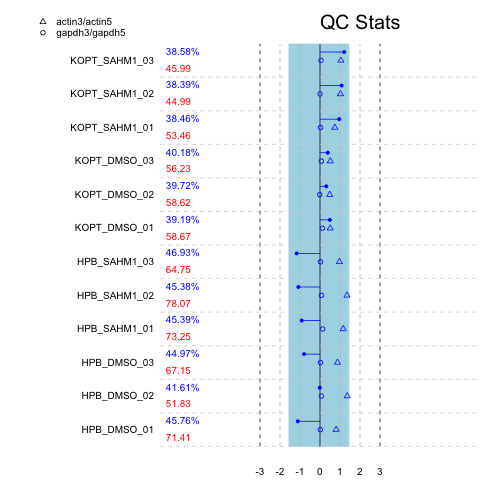

In [256]:
%%R

setwd("GSE18198_data")
affyBatch = import_CEL("*")
setwd(wd)
affyBatch_MAS5 <- call.exprs(affyBatch,"mas5")
qcs <- qc(affyBatch, affyBatch_MAS5)
plot(qcs)
qcs

## Load raw data

In [222]:
%%R
setwd("GSE18198_data")
affyBatch_HPB = import_CEL("HPB*")
affyBatch_KOPT = import_CEL("KOPT*")
setwd(wd)

## Create expression sets

In [223]:
%%R
eset_HPB <- create_eset(affyBatch_HPB)
eset_KOPT <- create_eset(affyBatch_KOPT)

background correction: rma 
normalization: quantiles 
PM/MM correction : pmonly 
expression values: medianpolish 
background correcting...done.
normalizing...done.
54675 ids to be processed
|                    |
|####################|
background correction: rma 
normalization: quantiles 
PM/MM correction : pmonly 
expression values: medianpolish 
background correcting...done.
normalizing...done.
54675 ids to be processed
|                    |
|####################|


In [224]:
%%R
save(eset_HPB, file="eset_HPB.RData")
save(eset_KOPT, file="eset_KOPT.RData")

## Quality plots

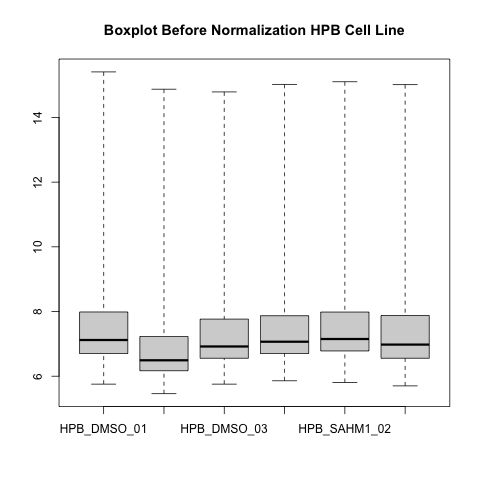

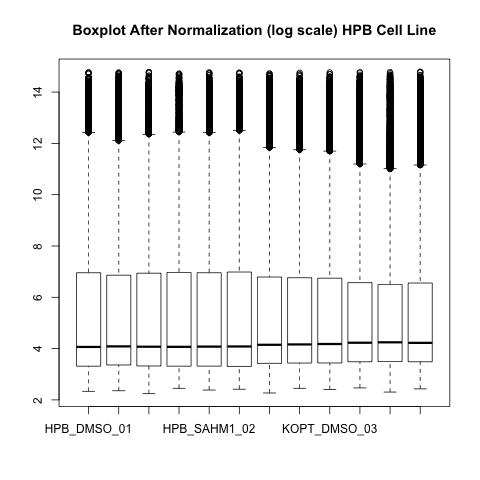

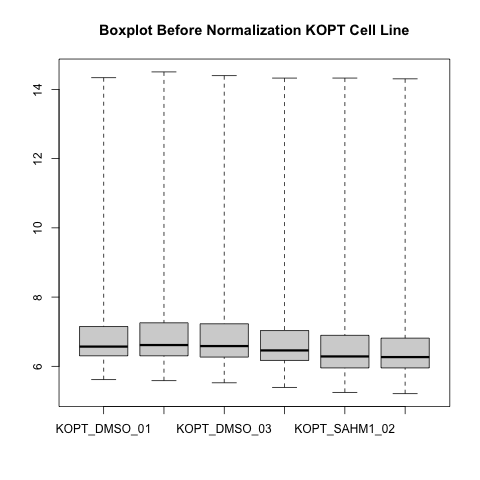

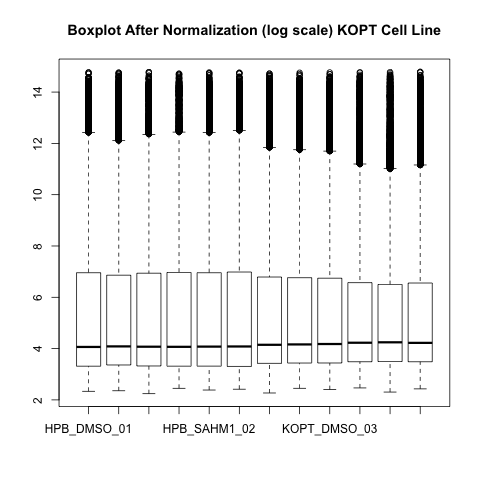

In [225]:
%%R
boxplots(affyBatch_HPB, eset, "HPB Cell Line")
boxplots(affyBatch_KOPT, eset, "KOPT Cell Line")

## Differential expressed genes

In [233]:
%%R
toptable_HPB <- create_TopTable(eset_HPB)
toptable_anot_HPB <- anotate_TopTable(toptable_HPB)
generank_table(toptable_anot_HPB, "generank_HPB")

[1] "Down-regulated genes"
               Symbol      logFC    adj.P.Val
225342_at         AK4 -2.1078858 1.128982e-05
230710_at    MIR210HG -1.9761492 7.688286e-06
227336_at        DTX1 -1.3841443 8.636324e-05
201842_s_at    EFEMP1 -1.3678548 6.004820e-05
204348_s_at       AK4 -1.3491612 3.350727e-04
227347_x_at      HES4 -1.2640712 1.228528e-04
200953_s_at     CCND2 -1.2357909 7.997079e-05
202464_s_at    PFKFB3 -1.1937490 1.228528e-04
202022_at       ALDOC -1.1753644 1.248092e-04
240546_at   LINC01120 -1.1131135 1.552628e-04
227337_at     ANKRD37 -1.1079168 2.110727e-04
200894_s_at     FKBP4 -1.0737202 5.300330e-04
217078_s_at    CD300A -1.0719092 8.239876e-04
201170_s_at   BHLHE40 -1.0402130 2.549012e-04
202934_at         HK2 -1.0377714 2.104071e-04
201848_s_at     BNIP3 -1.0052154 6.744018e-04
218051_s_at    NT5DC2 -1.0049990 2.851346e-03
203394_s_at      HES1 -0.9993973 7.294799e-04
219371_s_at      KLF2 -0.9800918 3.918155e-04
201251_at         PKM -0.9787897 4.328581e-03
201849_

In [234]:
%%R
toptable_KOPT <- create_TopTable(eset_KOPT)
toptable_anot_KOPT <- anotate_TopTable(toptable_KOPT)
generank_table(toptable_anot_KOPT, "generank_KOPT")

[1] "Down-regulated genes"
               Symbol     logFC    adj.P.Val
209921_at     SLC7A11 -2.916468 2.066610e-11
205047_s_at      ASNS -2.757747 2.764706e-11
209369_at       ANXA3 -2.661459 2.066610e-11
219270_at       CHAC1 -2.264373 7.569090e-10
226517_at       BCAT1 -2.216157 2.899776e-10
214452_at       BCAT1 -2.166267 3.402665e-09
225285_at       BCAT1 -2.072317 2.630231e-10
217678_at     SLC7A11 -2.058710 7.569090e-10
230748_at     SLC16A6 -2.004791 6.729951e-09
219892_at      TM6SF1 -1.957664 1.012031e-09
220892_s_at     PSAT1 -1.938100 4.136414e-10
204351_at       S100P -1.902944 5.924315e-09
223195_s_at     SESN2 -1.889417 7.569090e-10
214079_at       DHRS2 -1.873374 5.924315e-09
209822_s_at     VLDLR -1.863734 4.214321e-09
212290_at      SLC7A1 -1.860735 2.786337e-08
202847_at        PCK2 -1.828534 1.164949e-09
225520_at          NA -1.790127 1.147212e-09
223062_s_at     PSAT1 -1.786577 1.164949e-09
223196_s_at     SESN2 -1.730910 3.463629e-08
200924_s_at    SLC3A2 -1.698

## Generate GSEA gct, cls files

To send raw data, we need to process the expression data from affiBatch:

```R
exprs2_HPB <- cbind(featureNames(affyBatch_HPB), c(" "), exprs(affyBatch_HPB))
write.table(exprs2_HPB,row.names=FALSE,col.names=FALSE,quote=FALSE,file="eset_HPB.tsv", sep = "\t")
exprs2_KOPT <- cbind(featureNames(affyBatch_KOPT), c(" "), exprs(affyBatch_KOPT))
write.table(exprs2_KOPT,row.names=FALSE,col.names=FALSE,quote=FALSE,file="eset_KOPT.tsv", sep = "\t")
```

We decide to compute from expression set generated by expresso, in order to consume less processing time in GSEA. But we need to transform the expression amount to no log quantities.

In [269]:
%%R
exprs2_HPB <- cbind(c(" "), 2 ** exprs(eset_HPB))
write.table(exprs2_HPB,row.names=TRUE,col.names=FALSE,quote=FALSE,file="eset_HPB.tsv", sep = "\t")
exprs2_KOPT <- cbind(c(" "), 2 ** exprs(eset_KOPT))
write.table(exprs2_KOPT,row.names=TRUE,col.names=FALSE,quote=FALSE,file="eset_KOPT.tsv", sep = "\t")


In [270]:
%%bash
echo "#1.2" > gct.head.HPB
echo "$(cat eset_HPB.tsv | wc -l) 6" >> gct.head.HPB
echo "GID	NAME	HPB_DMSO_01	HPB_DMSO_02	HPB_DMSO_03	HPB_SAHM1_01	HPB_SAHM1_02	HPB_SAHM1_03" >> gct.head.HPB

echo "#1.2" > gct.head.KOPT
echo "$(cat eset_KOPT.tsv | wc -l) 6" >> gct.head.KOPT
echo "GID	NAME	KOPT_DMSO_01	KOPT_DMSO_02	KOPT_DMSO_03	KOPT_SAHM1_01	KOPT_SAHM1_02	KOPT_SAHM1_03" >> gct.head.KOPT

cat gct.head.HPB eset_HPB.tsv > eset_HPB.gct
cat gct.head.KOPT eset_KOPT.tsv > eset_KOPT.gct

echo "6	2	1" > phenotypes.cls
echo "#DMSO SAHM1" >> phenotypes.cls
echo "0	0	0	1	1	1" >> phenotypes.cls

## Processing all samples

In [214]:
%%R
setwd("GSE18198_data")
affyBatch = import_CEL("*")
setwd(wd)
eset <- create_eset(affyBatch)
toptable <- create_TopTable(eset, control_samples=c(1,1,1,0,0,0,1,1,1,0,0,0))
toptable_anot <- anotate_TopTable(toptable)
generank_table(toptable_anot, "generank")
save(eset, file="eset.RData")

background correction: rma 
normalization: quantiles 
PM/MM correction : pmonly 
expression values: medianpolish 
background correcting...done.
normalizing...done.
54675 ids to be processed
|                    |
|####################|
[1] "Down-regulated genes"
               Symbol      logFC      P.Value
227347_x_at      HES4 -1.2391846 4.541483e-05
227336_at        DTX1 -1.0787341 1.772044e-03
230263_s_at     DOCK5 -1.0589452 2.174812e-04
218051_s_at    NT5DC2 -0.9507155 1.126824e-03
205544_s_at       CR2 -0.9438572 5.961088e-05
202464_s_at    PFKFB3 -0.9408542 1.077045e-04
226452_at        PDK1 -0.8325181 2.019305e-05
223364_s_at     DHX37 -0.8207408 1.605856e-03
206686_at        PDK1 -0.8172945 9.936732e-04
203627_at       IGF1R -0.8050123 1.277490e-03
203867_s_at      NLE1 -0.7963720 7.746991e-04
204513_s_at     ELMO1 -0.7885410 1.839908e-04
207543_s_at     P4HA1 -0.7663495 3.287902e-05
212063_at        CD44 -0.7621344 1.769410e-03
227337_at     ANKRD37 -0.7620441 3.022164e-04
2

In [271]:
%%R
# Create files for GSEA
exprs2 <- cbind(c(" "), 2 ** exprs(eset))
write.table(exprs2, row.names=TRUE,col.names=FALSE, quote=FALSE,file="eset.tsv", sep = "\t")

In [272]:
%%bash
echo "#1.2" > gct.head
echo "$(cat eset.tsv | wc -l) 12" >> gct.head
echo "GID	NAME	HPB_DMSO_01	HPB_DMSO_02	HPB_DMSO_03	HPB_SAHM1_01	HPB_SAHM1_02	HPB_SAHM1_03	KOPT_DMSO_01	KOPT_DMSO_02	KOPT_DMSO_03	KOPT_SAHM1_01	KOPT_SAHM1_02	KOPT_SAHM1_03" >> gct.head
#head gct.head
cat gct.head eset.tsv > eset.gct

echo "12	2	1" > phenotypes_all.cls
echo "#DMSO SAHM1" >> phenotypes_all.cls
echo "0	0	0	1	1	1	0	0	0	1	1	1" >> phenotypes_all.cls

## GSEA results

See figures 1 to 8.

![Enrichment plot Notch Signalling Pathway](images/enplot_HALLMARK_NOTCH_SIGNALING_541.png "Enrichment plot Notch Signalling Pathway(Cell Line HPB-ALL)" )

![Gene sets enriched in phenotype DMSO(Cell Line HPB-ALL)](images/hallmark_HPB.jpg "Gene sets enriched in phenotype DMSO(Cell Line HPB-ALL)" )

![Heatmap(Cell Line HPB-ALL)](images/heatmap_HPB.png "Heatmap(Cell Line HPB-ALL)" )

![Gene sets enriched in phenotype DMSO(Cell Line KOPT-K1)](images/hallmark_KOPT.png "Gene sets enriched in phenotype DMSO(Cell Line KOPT-K1)" )

![Heatmap(Cell Line KOPT-K1)](images/heatmap_KOPT.png "Heatmap(Cell Line KOPT-K1)" )

![Gene sets enriched in phenotype DMSO(Cell Lines: HPB-ALL KOPT-K1)](images/hallmark_ALL.png "Gene sets enriched in phenotype DMSO(Cell Lines: HPB-ALL KOPT-K1)" )

![Heatmap(Cell Lines: HPB-ALL KOPT-K1)](images/heatmap_ALL.png "Heatmap(Cell Lines: HPB-ALL KOPT-K1)" )

![Heatmap(NOTCH signaling pathway)](images/heatmap_NOTCH.png "Heatmap(NOTCH signaling pathway)" )


## Methods

**Pipeline**

We have created the working environment under an i-python notebook of the *jupyter* platform configured to be able to execute R in code cells that start with *%%R*. To do so we have used the python package *rpy2*. This allows us to keep the documentation unified with the execution pipeline. It also becomes a good environment to launch hybrid pipelines with steps in R, python or even bash. It would not be difficult to develop on top a checkpoint and restart system for those developments highly time consuming.

The interface with python has not been necessary but we have developed in *bash* part of the conversions to the *gct* format and the generation of phenotype files (*.cls*). We use the expression set tranformed by *expresso* method from _affy_ package as input on GSEA.

In R we used the *affy*, *limma*, and *simpleaffy* libraries and developed a pipeline similar to the one followed in the lectures. We group in functions the most used methods to be able to launch in a more compact way the different experiments.

**Input data**

We download from the GEO platform the raw data belonging to expression arrays Human Genome U133 Plus 2.0 with code *GSE18198*. These data have RNA information from cell cultures of the KOPT-K1 and HPB-ALL lines treated for 24h with SAHM1. Also their respective controls with the same amount of DMSO.

**Analysis strategy**

The quality analysis is carried out with the MAS 5.0 algorithm provided by simpleaffy.

The two cell lines were analyzed separately and jointly in R-limma and in GSEA.

In R-limma we use the Benjamini, Hochberg algorithm to control the false discovery rate derived from multiple testing and obtain adjusted p-values.

Before to fit the model in limma, we call the expresso command to got background correction, normalization and summarization to $log_2$ values.

The conversion to GSEA is done from the expression set obtained from the expresso command. Then we perform the conversions to the gct format.

The results in GSEA and R are coherent, at least in regard to our target: NOTCH signaling pathway on which we have concentrated exclusively.

## Discusion

### Quality

We use the simpleaffy R package that generates a series of metrics recommended by the manufacturer Affymetrix:

1. Average background
2. Scale factor
3. Percentage of genes called present.
4. 3' to 5' ratios (related with RNA degradation)

It is observed that all the indicators are within the acceptance margins (see graph of section 1.5), but that the patterns are clearly different between the samples of both cell lines.


### Differential expression

We performed three different analysis to discover the effectiveness of SAHM1 in the inhibition of NOTCH.

1. Comparison between control (DMSO) and inhibitor (SAHM1) in the HBP-ALL cell line.
2. Comparison between control (DMSO) and inhibitor (SAHM1) in the KOPT-K1 cell line.
3. Comparison between control (DMSO) and inhibitor (SAHM1) joint for both cell lines.

It seems more correct to isolate each cell line separately in the analysis, according to the results of the quality analysis, where the expression patterns within cell lines appear more homogeneous than between. However, in figure 3 of the paper a heatmap is shown where the 12 samples seem to have been treated together, so we reproduced this analysis in case it could really show significant differences with the individual ones.

On the HPB-ALL cell line (1.9) and on the analysis of the two lines together (1.11) we found several direct targets of Notch TF among the 50 most significantly infra-regulated probes on inhibition scenario (lowest values of adjusted p-value and logFC <0): HES1, HES4, and DTX1, which are also investigated in the article.
This result is also reproduced in the parallel analysis performed on GSEA. See figures 3 & 7.

GSEA also provides hallmarks that are overexpressed in the absence of inhibitory treatment, and among them we find Notch signaling (figures 2, 4 ,6)

The ES plots of the notch signalling pathway show that their gen-set is overrepresented in the high zone of the ranking in both cell lines. Figure 1 shows the one calculated for HPB-ALL.

These results are compatible with the expected effectiveness of SAHM1 as a NOTCH inhibitor.

In the analysis on the KOPT-K1 line, the hallmark NOTCH signaling still appears overexpressed in absence of inhibitor, but there are only traces of HES4  in the GSEA heatmap. 

To get more insights we need to dive into notch hallmark in GSEA analysis.

So, for GSEA analysis performed in both cell-lines, we see (figure 8) that HES1, DTX1 and NOTCH homologous are under-expressed in treated samples, confirming the paper results. 

### Other results

We have not included them in this document, but we have also worked against GSEA from the raw experimental data, starting directly from the *affiBatch* object. The conversion to *gct* is somewhat different and is detailed in [1.7]. We have not time to analyze this results.

Another hallmark that I analyse are the MYC_targets (figures 9 and 10). MYC is mentioned at the paper and we have found articles that relate this with NOTCH signaling ("NOTCH1 directly regulates c-MYC and activates a feed-forward-loop transcriptional network promoting leukemic cell growth", Teresa Palomero et al.). 

Also it is overrepresented in the upper area of the ranking related to control cells:

![Enrichment plot MYC Target Pathway (HPB-ALL)](images/enplot_HALLMARK_MYC_TARGETS_V2_1470_HPB.png "Enrichment plot MYC targets(Cell Line HPB-ALL)" )

![Enrichment plot MYC Target Pathway (KNOPT-K1)](images/enplot_HALLMARK_MYC_TARGETS_V2_1470.png "Enrichment plot MYC targets(Cell Line KNOPT-K1)" )

### Conclusions

These results seem to confirm that the designed peptide is carrying out the desired functions related to the inhibition of the NOTCH signaling pathway, although we have not been able to delimit the targets in the same way as in the article, especially in the analysis of the cell line KOPT-K1.


_It has become clear to me, as on other occasions, that differences between computational procedures can give rise to subtle and sometimes not so subtle differences between the data obtained. It is more than necessary to execute analysis with several tools, at least three. In this case we have done it with two: GSEA and R-limma, but in GSEA we do not input raw data, so being strict, we would not be following our own recommendations. Still, there are differences._

_Another practice that we believe is advisable is to have a highly tested homemade version of the main algorithms. This can help to analyze the reliability of the software used. It's not necessary that this type of code be highly optimized._

# Outputs

In [285]:
%%bash
jupyter nbconvert --to=latex --template=~/report.tplx TRREP_final.ipynb 1> /dev/null 2> /dev/null
/Library/TeX/texbin/pdflatex -shell-escape TRREP_final 1> /dev/null 2> /dev/null
jupyter nbconvert --to html_embed --template toc2 TRREP_final.ipynb 1> /dev/null 2> /dev/null